# Videogame Recommendation System Using Steam Reviews
Gerardo Gómez Argüelles, Tirdod Behbehani, & Oliver Tausendschön

# Data Pre-Processing

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
steam = pd.read_csv("Steam_Reviews.csv")
steam

,Game,Review,Recommended,Genre
0,Company of Heroes 3,I still believe CoH2 is the superior choice cu...,False,"Action, Strategy"
1,Company of Heroes 3,I Pre-ordered the premium edition version of t...,False,"Action, Strategy"
2,Company of Heroes 3,"An underwhelming, expensive cash grab. Very lo...",False,"Action, Strategy"
3,Company of Heroes 3,Here is my actual review. COH3 has the best Qo...,True,"Action, Strategy"
4,Company of Heroes 3,They listed my GPU as supported and then quiet...,False,"Action, Strategy"
...,...,...,...,...
40644,Baldur's Gate 3,It's not just a game! It's a whole story that ...,True,"Adventure, RPG, Strategy"
40645,Baldur's Gate 3,It's the closest you're going to get to playin...,True,"Adventure, RPG, Strategy"
40646,Baldur's Gate 3,verry gooood gammeeee. I slept on it for to lo...,True,"Adventure, RPG, Strategy"
40647,Baldur's Gate 3,Funny wild magic sorceror Durge run made every...,True,"Adventure, RPG, Strategy"


First we will add Boolean variables per genre to get metadata of the games we scraped

In [ ]:
max_commas = steam['Genre'].str.count(',').max()
print("Maximum number of commas in Genre column:", max_commas)

# Split the 'Genre' column by commas and stack the resulting lists into a single series
unique_genres = steam['Genre'].str.split(',').explode().str.strip().unique()

# Print the unique values
print("Unique Genres:", unique_genres)

# Print the number of unique values
print("Number of Unique Genres:", len(unique_genres))

for genre in unique_genres:
    steam[genre] = steam['Genre'].str.contains(genre).astype(bool)
    

steam.columns = [col.replace(' ', '_') for col in steam.columns]

# Display the first few rows to verify the new column names
steam.head()

In [4]:
print("There are", steam["Game"].nunique(), "games and a total of", steam.__len__(),"reviews")

There are 97 games and a total of 40649 reviews


In [5]:
for game, count in steam["Game"].value_counts().items():
    print(f"There are {count} reviews in the game {game}")

There are 1200 reviews in the game PUBG: BATTLEGROUNDS
There are 1200 reviews in the game Phasmophobia
There are 800 reviews in the game The Witcher 3: Wild Hunt
There are 800 reviews in the game Dying Light
There are 800 reviews in the game Valheim
There are 800 reviews in the game Dead by Daylight
There are 800 reviews in the game Euro Truck Simulator 2
There are 796 reviews in the game Battlefield 4™
There are 796 reviews in the game Grand Theft Auto V Legacy
There are 792 reviews in the game Cookie Clicker
There are 762 reviews in the game Age of Empires II: Definitive Edition
There are 738 reviews in the game Europa Universalis IV
There are 584 reviews in the game 100% Orange Juice
There are 400 reviews in the game Titanfall® 2
There are 400 reviews in the game Keep Driving
There are 400 reviews in the game Resident Evil 4
There are 400 reviews in the game Warhammer 40,000: Space Marine 2
There are 400 reviews in the game Elite Dangerous
There are 400 reviews in the game Dead Cell

# Statistics of our Data Set:

To gain more insights on our data set we will analyze some of intresting metadata.

/var/folders/qq/ny6dn2_d5wl2yjtn17gtz13r0000gn/T/ipykernel_90484/118637846.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_games.values, y=top_games.index, palette="viridis")


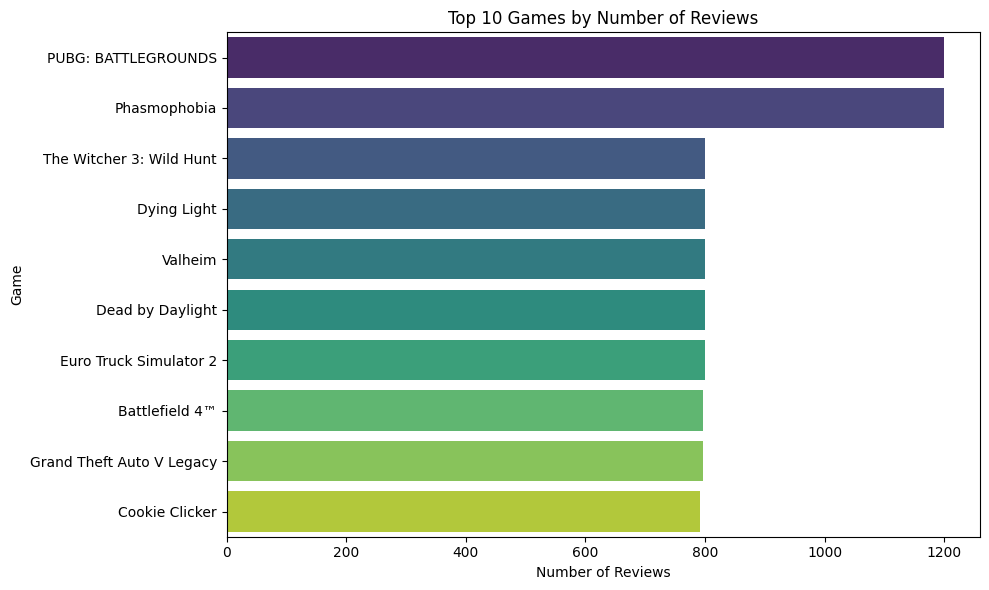

In [74]:
# Figure 1: Top 10 Games by Number of Reviews

top_games = steam['Game'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_games.values, y=top_games.index, palette="viridis")
plt.title("Top 10 Games by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Game")
plt.tight_layout()
plt.show()



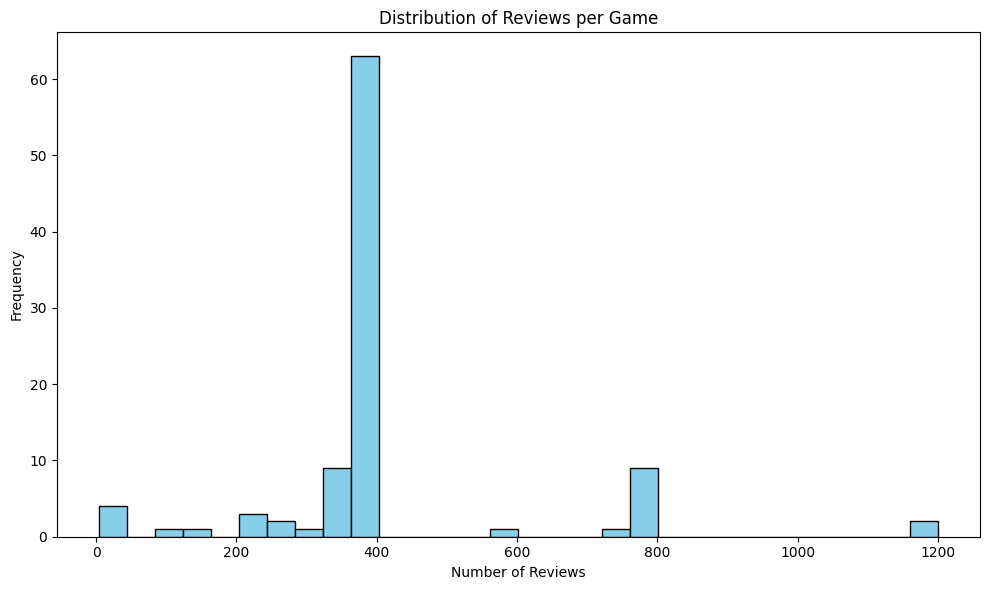

In [76]:
# Figure 2: Distribution of Reviews per Game

review_counts = steam['Game'].value_counts()
plt.figure(figsize=(10,6))
plt.hist(review_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Reviews per Game")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



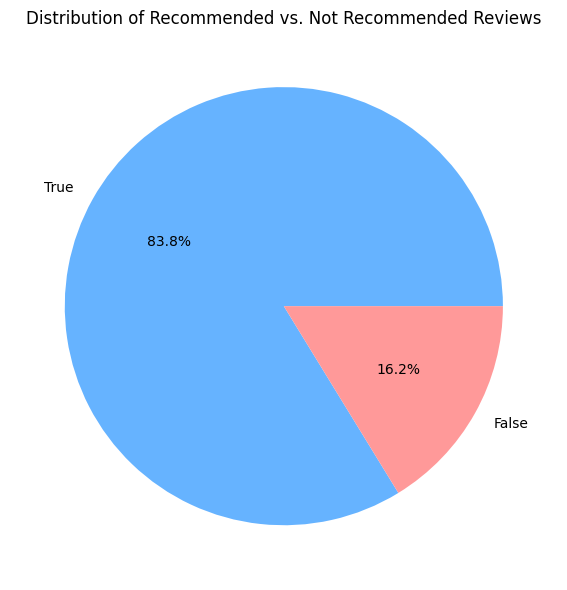

In [70]:
# Figure 3: Recommended vs. Not Recommended Reviews

if 'Recommended' in steam.columns:
    rec_counts = steam['Recommended'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(rec_counts, labels=rec_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    plt.title("Distribution of Recommended vs. Not Recommended Reviews")
    plt.tight_layout()
    plt.show()

A closer examination of the recommended variable reveals a significant imbalance: there are 34,045 positive reviews compared to only 6,604 negative reviews. As shown in this figure, this skew may initially raise concerns regarding data balance, yet it also mirrors a common phenomenon observed in user-generated content on platforms like Steam, where gamers tend to post positive feedback more frequently than negative. 

# Text Pre Processing

Our data preprocessing phase was designed to transform raw game reviews into a clean and uniform format that would enable effective TF-IDF analysis and reliable recommendations. Initially, our focus was on text cleaning using lemmatization with spaCy. This allowed us to reduce words to their base forms, consolidating similar words like "running" into "run", thereby reducing redundancy in our dataset. 

In [6]:
import os
import re
import csv
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

from scipy.stats import pearsonr

# Function to download NLTK resources
def download_nltk_resources():
    required_resources = ['wordnet', 'stopwords', 'punkt']
    for resource in required_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Function to install and load spaCy model
def install_spacy_model(model_name):
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model: {model_name}")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return spacy.load(model_name)

sp = install_spacy_model('en_core_web_sm')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize stemmers and lemmatizer
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tirdodbehbehani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We will use the module seen in class as it is extremely usefull for this part of our project.

In [10]:
"""
This module provides helper functions for text preprocessing. 
Each function applies punctuation removal and stopword removal, and then one of three options:
    0: Lowercasing only.
    1: Lowercasing plus stemming.
    2: Lemmatizing (using spaCy; original casing is preserved).

The functions return a string of tokens separated by spaces.
"""


def preprocess_lower(text):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords.
    
    Returns:
        str: A string of filtered tokens separated by spaces.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return " ".join(filtered_tokens)

def preprocess_stem(text):
    """
    Preprocess text by performing all steps in preprocess_lower() and then applying stemming.
    
    Returns:
        str: A string of stemmed tokens separated by spaces.
    """
    tokens = preprocess_lower(text).split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)


# Function to remove emojis and special characters
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove HTML-like tags [b], [i], etc.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keeps letters, numbers, and spaces
    return text

# Updated preprocess_lemma function
def preprocess_lemma(text):
    """
    Preprocess text by:
       - Removing special characters, emojis, and HTML tags.
       - Lemmatizing the text using spaCy.
       - Keeping only alphabetic words (removes numbers & symbols).
    
    Returns:
        str: A string of lemmatized words separated by spaces.
    """
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")
    text = clean_text(text)  # Remove special characters
    text = preprocess_lower(text)  # Lowercase and remove stopwords
    doc = nlp(text)  # Process text with spaCy
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]  # Keep only words
    return " ".join(lemmatized_tokens)



def tokenize(text, mode=0):
    """
    General tokenize function. Always applies punctuation and stopword removal and then:
    
      mode = 0: Applies lowercasing.
      mode = 1: Applies lowercasing and stemming.
      mode = 2: Applies lemmatization (without lowercasing the original text).
    
    Args:
        text (str): The input text to be processed.
        mode (int): Processing mode (0 for lowercasing; 1 for stemming; 2 for lemmatizing).

    Returns:
        str: A string of processed tokens separated by spaces.

    Raises:
        ValueError: If an invalid mode is provided.
    """
    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

During our preprocessing, we encountered a common challenge in the gaming community: the pervasive use of emojis and HTML-like tags. Although these elements are frequently used by gamers, they do not add useful information and are often overly repeated. To address this, we incorporated an extra regex function in the module we used specifically to remove emojis and HTML-like tags. In the following code we will show an example of what we encountered.

In [63]:
# Select a specific review that has special characters
test_review = steam.loc[3076, "Review"]  # Row index we want to test

print("Original Review:")
print(test_review)

# Apply the function to one review
processed_test_review = preprocess_lemma(test_review)

print("\nProcessed Review:")
print(processed_test_review)



Original Review:
🌀 Portal 2 – A Timeless Masterpiece of Puzzle and Wit 🎭
🔹 Developer: Valve
🔹 Genre: Puzzle-Platformer
🔹 Release Date: April 18, 2011
🔹 Platforms: PC, PS3, Xbox 360, macOS, Linux

✨ The Cake May Be a Lie, But the Brilliance is Real!
Portal 2 isn’t just a game—it’s an intellectual playground that challenges your mind, tickles your funny bone, and immerses you in a world where physics, storytelling, and humor collide in perfect harmony. Valve took the innovative mechanics of the original Portal and expanded them into a fully fleshed-out masterpiece that still stands as one of the greatest games ever made.

🧩 Gameplay – A Brain-Bending Work of Art
At its core, Portal 2 is a first-person puzzle-platformer where you use the iconic Portal Gun to place two linked portals on surfaces, allowing for mind-bending traversal and puzzle-solving. But Valve went beyond simple portals:

✅ New Mechanics – Exciting additions like Gels (speed, bounce, and portal-friendly surfaces), Light B

In [12]:
#Getting the clean text column
mod=2 #Lemmatizing

# Pre-process the text column with progress tracking
try:
    steam["cleaned_review"] = steam["Review"].progress_apply(lambda x: tokenize(str(x), mod))
    print("Done processing text.")
except Exception as e:
    print(f"Error processing text column: {e}")
    sys.exit(1)


100%|██████████| 40649/40649 [7:01:23<00:00,  1.61it/s]      

Done processing text.


In [23]:
steam.to_csv("all_Steam_Reviews_cleaned_1.csv", index=False)

Now that we get the Steam Reviews Cleaned we will analyze it and split it into positive reviews and negative reviews for further analysis.

In [64]:
steam_reviews= pd.read_csv("all_Steam_Reviews_cleaned_1.csv")
steam_reviews

,game,review,recommended,genre,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,cleaned_review
0,Company of Heroes 3,I still believe CoH2 is the superior choice cu...,False,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,believe superior choice currently not triedgot...
1,Company of Heroes 3,I Pre-ordered the premium edition version of t...,False,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,preordere premium edition version game put hun...
2,Company of Heroes 3,"An underwhelming, expensive cash grab. Very lo...",False,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,underwhelme expensive cash grab low content su...
3,Company of Heroes 3,Here is my actual review. COH3 has the best Qo...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,actual review good qol franchise stop play fav...
4,Company of Heroes 3,They listed my GPU as supported and then quiet...,False,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,list gpu support quietly patch support year re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40644,Baldur's Gate 3,It's not just a game! It's a whole story that ...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,game story completely immerse primarily thank ...
40645,Baldur's Gate 3,It's the closest you're going to get to playin...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,close go play dnd group friend willing sit pla...
40646,Baldur's Gate 3,verry gooood gammeeee. I slept on it for to lo...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,verry gooood gammeeee sleep long finish ton co...
40647,Baldur's Gate 3,Funny wild magic sorceror Durge run made every...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,funny wild magic sorceror durge run turn cat t...


In [ ]:
positive_reviews = steam_reviews[steam_reviews["Recommended"] == 1]
negative_reviews = steam_reviews[steam_reviews["Recommended"] == 0]

In [28]:
positive_reviews.to_csv("positive_steam_reviews_1.csv", index=False)
negative_reviews.to_csv("negative_steam_reviews_1.csv", index=False)

# Genre Frequency

After getting all the reviews and cleaning them we decided to explore the amount of genres we have in our data as this will be important to consider when we get our recommendations. The figure shows that action is the most prevalent genre in our dataset, followed by adventure and rpg. This genre distribution suggests that certain game types might dominate user attention, potentially influencing the performance of our recommendation system if not carefully accounted for.

/var/folders/qq/ny6dn2_d5wl2yjtn17gtz13r0000gn/T/ipykernel_90484/2850296462.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")


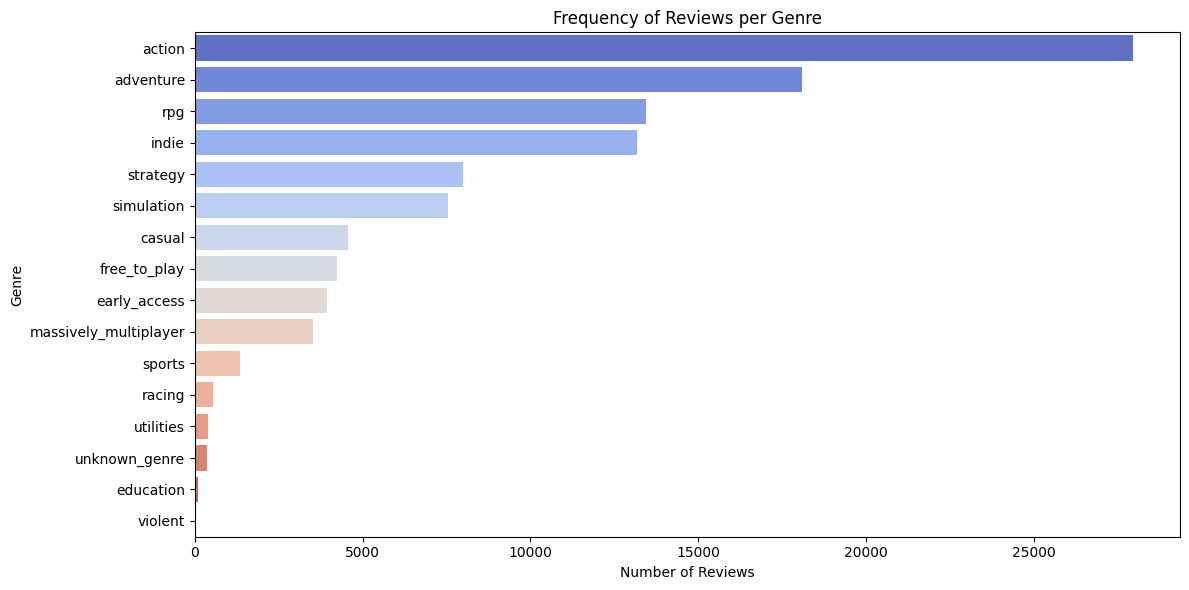

In [ ]:
# Figure 4: Genre Frequency in Reviews
# List of Unique Genres
unique_genres = ['action', 'strategy',
                'free_to_play', 'adventure', 'massively_multiplayer', 'indie', 'rpg',
                'casual', 'racing', 'early_access', 'simulation', 'unknown_genre',
                'sports', 'violent', 'education', 'utilities']


# Create a count for each genre by summing the boolean indicator columns
genre_counts = {}
for genre in unique_genres:
    genre_counts[genre] = steam_reviews[genre.lower()].sum() # Using columns for each genre 

genre_counts = pd.Series(genre_counts).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="coolwarm")
plt.title("Frequency of Reviews per Genre")
plt.xlabel("Number of Reviews")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()
